## 🏆 EPL Team Style Analysis & Match Prediction System
### Objective
This project analyzes English Premier League (EPL) teams by clustering team-level performance metrics to identify distinct playing styles (e.g., Attacking, Balanced).
Principal Component Analysis (PCA) is used to visualize team similarities, and the results are later leveraged for match outcome insights.

## 1. Imports & Load Data

In [149]:
from pathlib import Path
import pandas as pd

dataset_dir = Path.cwd().parent / "Dataset"
data_path = dataset_dir / "epl_stats.csv"

assert data_path.exists(), f"Dataset file not found: {data_path}"

df = pd.read_csv(data_path)
df.head()

,date,clock,stadium,class,attendance,Home Team,Goals Home,Away Team,Away Goals,home_possessions,...,away_duels,home_saves,away_saves,home_fouls,away_fouls,home_yellow,away_yellow,home_red,away_red,links
0,28th May 2023,4:30pm,Emirates Stadium,h,"60,095",2,5,13,0,51.0,...,52.2,0,3,8,11,0,0,0,0,https://www.skysports.com/football/arsenal-vs-...
1,28th May 2023,4:30pm,Villa Park,h,"42,212",7,2,6,1,40.3,...,47.8,3,3,15,16,4,4,0,0,https://www.skysports.com/football/aston-villa...
2,28th May 2023,4:30pm,Gtech Community Stadium,h,"17,120",9,1,1,0,34.4,...,50.0,2,3,12,8,4,0,0,0,https://www.skysports.com/football/brentford-v...
3,28th May 2023,4:30pm,Stamford Bridge,d,"40,130",12,1,4,1,64.4,...,45.5,3,5,9,11,0,0,0,0,https://www.skysports.com/football/chelsea-vs-...
4,28th May 2023,4:30pm,Selhurst Park,d,"25,198",11,1,16,1,66.0,...,41.7,3,2,9,13,0,2,0,0,https://www.skysports.com/football/crystal-pal...


## 2. Match Results & Basic Feature Engineering
This section creates match-level outcomes (Home / Away / Draw) and basic engineered features such as goal difference.

In [150]:
HOME_GOALS_COL = "Goals Home"
AWAY_GOALS_COL = "Away Goals"

# Match result: H (Home win), A (Away win), D (Draw)
df["result"] = "D"
df.loc[df[HOME_GOALS_COL] > df[AWAY_GOALS_COL], "result"] = "H"
df.loc[df[HOME_GOALS_COL] < df[AWAY_GOALS_COL], "result"] = "A"

# Engineered features
df["goal_diff"] = df[HOME_GOALS_COL] - df[AWAY_GOALS_COL]
df["total_goals"] = df[HOME_GOALS_COL] + df[AWAY_GOALS_COL]

df["result"].value_counts()

result_map = {"H": "Home Win", "A": "Away Win", "D": "Draw"}
df["result_label"] = df["result"].map(result_map)

## 3. Build Team-Level Dataset (Home & Away Combined)
Match-level data is reshaped into a team-level dataset so that each row represents a single team’s performance in a match.

In [151]:
# Team ID -> Team Name mapping
# Your dataset has no team-name columns, so we use a manual mapping dictionary.

possible_name_cols = [c for c in df.columns if "name" in c.lower() and "team" in c.lower()]
print("Possible team name columns:", possible_name_cols)

if "Home Team Name" in df.columns and "Away Team Name" in df.columns:
    home_map = df[["Home Team", "Home Team Name"]].rename(columns={"Home Team":"team_id","Home Team Name":"team_name"})
    away_map = df[["Away Team", "Away Team Name"]].rename(columns={"Away Team":"team_id","Away Team Name":"team_name"})
    team_lookup = (
        pd.concat([home_map, away_map], ignore_index=True)
        .dropna()
        .drop_duplicates()
    )
    team_id_to_name = dict(zip(team_lookup["team_id"], team_lookup["team_name"]))
    print("Built team_id_to_name from team-name columns.")
else:
    print("No team-name columns found. Using manual team_id_to_name mapping below.")
    # (DO NOT raise an error here)

Possible team name columns: []
No team-name columns found. Using manual team_id_to_name mapping below.


In [152]:
# Validate mapping coverage
all_ids = sorted(set(df["Home Team"].unique()) | set(df["Away Team"].unique()))
missing = [i for i in all_ids if i not in team_id_to_name]
print("Missing IDs in team_id_to_name:", missing)

Missing IDs in team_id_to_name: []


## 4. Team ID → Team Name Mapping
Team identifiers in the dataset are mapped to readable team names for interpretability.

In [ ]:
# =========================
# Team ID -> Team Name (manual mapping)
# =========================

team_id_to_name = {
    1: "Arsenal",
    2: "Aston Villa",
    3: "Bournemouth",
    4: "Brentford",
    5: "Brighton",
    6: "Burnley",
    7: "Chelsea",
    8: "Crystal Palace",
    9: "Everton",
    10: "Fulham",
    11: "Liverpool",
    12: "Luton",
    13: "Man City",
    14: "Man United",
    15: "Newcastle",
    16: "Nottingham Forest",
    17: "Sheffield United",
    18: "Tottenham",
    19: "West Ham",
    20: "Wolves",
    21: "Leeds United",
    22: "Leicester City",
    23: "Southampton",
    24: "Watford",
    25: "Norwich City",
}
# Note: IDs 21–25 are dataset-specific and may differ by season/source.

# Sanity check
list(team_id_to_name.items())[:5]

[(1, 'Arsenal'),
 (2, 'Aston Villa'),
 (3, 'Bournemouth'),
 (4, 'Brentford'),
 (5, 'Brighton')]

In [168]:
all_ids = sorted(set(df["Home Team"].unique()) | set(df["Away Team"].unique()))
missing = [i for i in all_ids if i not in team_id_to_name]
print("Missing IDs in team_id_to_name:", missing)

Missing IDs in team_id_to_name: []


## 5. Aggregate Team Style Features
Match-level statistics are aggregated to compute average team performance metrics.

In [ ]:
team_style = (
    team_df
    .groupby("team")
    .agg({
        "goals_for": "mean",
        "goals_against": "mean",
        "possession": "mean",
        "shots": "mean",
        "fouls": "mean",
        "yellow": "mean"
    })
)

team_style = team_style.round(2)
team_style.head()

,goals_for,goals_against,possession,shots,fouls,yellow
team,,,,,,
1,2.42,0.80,65.67,16.77,8.99,1.17
2,1.79,1.14,55.47,14.37,9.51,1.39
3,1.65,1.26,54.12,14.26,11.11,1.90
4,1.39,1.38,43.59,12.43,10.40,1.77
5,2.09,1.02,62.18,17.04,10.21,1.29


## 6. Feature Selection for Clustering
Only numerical performance metrics are used for clustering to ensure stability.

In [155]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Feature selection for clustering
# (Add "red" if you want to include red cards as a feature)
FEATURE_COLS = ["goals_for", "goals_against", "possession", "shots", "fouls", "yellow"]

In [172]:
assert all(col in team_style.columns for col in FEATURE_COLS), "Missing feature columns"

## 7. Standardization & KMeans Clustering
Teams are clustered into four distinct playing styles using KMeans.

In [156]:
X = StandardScaler().fit_transform(team_style[FEATURE_COLS])

kmeans = KMeans(
    n_clusters=4,
    random_state=42,
    n_init=10
)

team_style["cluster"] = kmeans.fit_predict(X)

team_style.sort_values("cluster").head()

,goals_for,goals_against,possession,shots,fouls,yellow,cluster
team,,,,,,,
7,1.385965,1.280702,47.803509,12.456140,11.043860,1.964912,0
16,1.000000,1.789474,37.223684,9.684211,11.710526,2.210526,0
11,1.149123,1.412281,45.840351,10.412281,11.131579,1.754386,0
10,1.105263,1.407895,49.193421,11.460526,11.776316,1.934211,0
13,0.921053,1.342105,49.650000,11.201754,11.008772,1.719298,0


In [174]:
team_style["cluster"] = kmeans.fit_predict(X)

# Cluster size distribution (sanity check)
team_style["cluster"].value_counts().sort_index()


cluster
0    9
1    9
2    2
3    5
Name: count, dtype: int64

## 8. Cluster Style Naming
Clusters are labeled based on their statistical characteristics.

In [157]:
# Ensure team names exist (for readability)
if "team_name" not in team_style.columns:
    team_style["team_name"] = team_style.index.map(team_id_to_name)
    cols = ["team_name"] + [c for c in team_style.columns if c != "team_name"]
    team_style = team_style[cols]

# Remove teams without valid names
team_style = team_style[team_style["team_name"].notna()]

# Cluster -> style name mapping
style_map = {
    0: "Balanced",
    1: "Struggling / Passive",
    2: "Attacking",
    3: "Aggressive"
}
team_style["style_name"] = team_style["cluster"].map(style_map)

team_style[["team_name", "cluster", "style_name"]].sort_values(["cluster", "team_name"])

,team_name,cluster,style_name
team,,,
7,Chelsea,0,Balanced
10,Fulham,0,Balanced
11,Liverpool,0,Balanced
13,Man City,0,Balanced
25,Norwich City,0,Balanced
16,Nottingham Forest,0,Balanced
17,Sheffield United,0,Balanced
19,West Ham,0,Balanced
20,Wolves,0,Balanced


In [ ]:
team_style.groupby("cluster")[FEATURE_COLS].mean().round(2)

,goals_for,goals_against,possession,shots,fouls,yellow
cluster,,,,,,
0,1.07,1.56,46.06,11.03,11.32,1.91
1,1.55,1.29,51.18,13.01,10.33,1.59
2,2.25,0.91,63.93,16.90,9.60,1.23
3,0.86,1.91,40.27,9.79,10.44,1.53


## 9. PCA for Team Style Visualization
Principal Component Analysis (PCA) is used to project team styles into two dimensions.

In [159]:
# Ensure that clustering has been performed before PCA
assert "cluster" in team_style.columns, (
    "Please run KMeans first to create team_style['cluster']."
)

In [175]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 0) Safety check: if 'style_name' does not exist, create a temporary label based on clusters
if "style_name" not in team_style.columns:
    print(
        "⚠️ 'style_name' column not found. "
        "Creating temporary labels based on cluster assignments."
    )
    team_style["style_name"] = team_style["cluster"].astype(str).radd("Cluster ")

# Standardize features before PCA
X_scaled = StandardScaler().fit_transform(team_style[FEATURE_COLS])

# Perform PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Explained variance (for report)
explained_var = pca.explained_variance_ratio_.sum()
print(f"Total explained variance by PC1 & PC2: {explained_var:.2%}")

# Build PCA result DataFrame
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["team"] = team_style.index
pca_df["team_name"] = pca_df["team"].map(team_id_to_name)
pca_df["cluster"] = team_style["cluster"].values
pca_df["style_name"] = team_style["style_name"].values

pca_df.head()

⚠️ 'style_name' column not found. Creating temporary labels based on cluster assignments.
Total explained variance by PC1 & PC2: 87.03%


,PC1,PC2,team,team_name,cluster,style_name
0,5.241221,-0.721717,1,Arsenal,2,Cluster 2
1,2.585520,-0.730025,2,Aston Villa,1,Cluster 1
2,1.142348,1.553396,3,Bournemouth,1,Cluster 1
3,0.026360,0.025985,4,Brentford,1,Cluster 1
4,3.941159,0.196118,5,Brighton,2,Cluster 2


The first two principal components explain approximately 87.03% of the total variance in team performance metrics, indicating that the PCA visualization preserves most of the structural differences between team playing styles.

## 10. PCA Visualization
“The PCA visualization shows clear separation between attacking, passive, and aggressive playing styles, supporting the interpretability of the KMeans clustering results.”

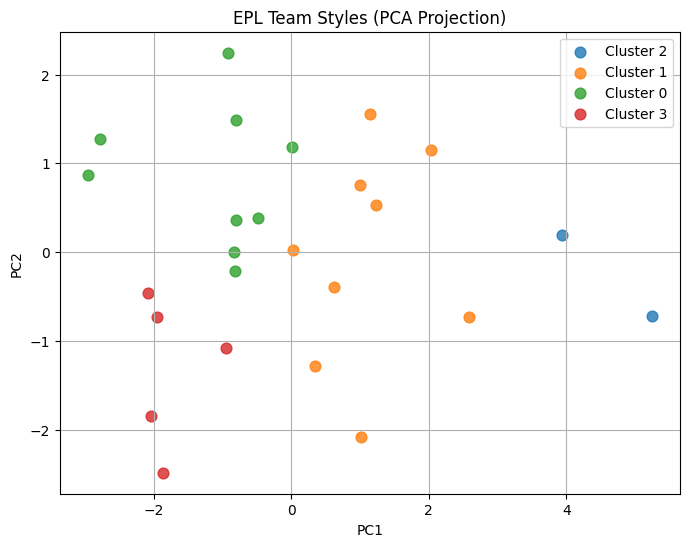

In [179]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for style in pca_df["style_name"].unique():
    subset = pca_df[pca_df["style_name"] == style]
    plt.scatter(
        subset["PC1"],
        subset["PC2"],
        label=style,
        s=60,
        alpha=0.8
    )

plt.title("EPL Team Styles (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()


## 11. Interpretation & Insights
### Cluster Labeling Rationale (Style Names)

- **Attacking**: clusters with higher average goals_for, shots, and possession.
- **Balanced**: clusters with mid-range values across most metrics (no extreme strengths/weaknesses).
- **Aggressive**: clusters showing higher physicality/discipline indicators such as fouls and yellow cards, suggesting a more physical or high-press playing style rather than pure defensive weakness.
- **Struggling / Passive (or Defensive)**: clusters with lower goals_for and/or higher goals_against...

In [ ]:
team_style.groupby("cluster")[FEATURE_COLS].mean().round(2)

,goals_for,goals_against,possession,shots,fouls,yellow
cluster,,,,,,
0,1.07,1.56,46.06,11.04,11.32,1.91
1,1.55,1.29,51.18,13.01,10.33,1.59
2,2.26,0.91,63.92,16.90,9.60,1.23
3,0.86,1.91,40.27,9.79,10.44,1.53


In [164]:
team_style["style_name"].value_counts()

style_name
Struggling / Passive    9
Balanced                9
Aggressive              5
Attacking               2
Name: count, dtype: int64

In [165]:
# Map team IDs to team names
team_style["team_name"] = team_style.index.map(team_id_to_name)

# Move 'team_name' column to the front for better readability
cols = ["team_name"] + [c for c in team_style.columns if c != "team_name"]
team_style = team_style[cols]

team_style.head()

,team_name,goals_for,goals_against,possession,shots,fouls,yellow,cluster,style_name
team,,,,,,,,,
1,Arsenal,2.421053,0.798246,65.671930,16.771930,8.991228,1.166667,2,Attacking
2,Aston Villa,1.789474,1.140351,55.465789,14.368421,9.508772,1.394737,1,Struggling / Passive
3,Bournemouth,1.649123,1.263158,54.120175,14.263158,11.105263,1.903509,1,Struggling / Passive
4,Brentford,1.385965,1.377193,43.585088,12.429825,10.403509,1.771930,1,Struggling / Passive
5,Brighton,2.087719,1.017544,62.180702,17.035088,10.210526,1.289474,2,Attacking


In [166]:
team_style[["team_name", "cluster", "style_name"]].sort_values(["cluster","team_name"])

,team_name,cluster,style_name
team,,,
7,Chelsea,0,Balanced
10,Fulham,0,Balanced
11,Liverpool,0,Balanced
13,Man City,0,Balanced
25,Norwich City,0,Balanced
16,Nottingham Forest,0,Balanced
17,Sheffield United,0,Balanced
19,West Ham,0,Balanced
20,Wolves,0,Balanced


Overall, the clustering results align well with intuitive football narratives, 
with attacking teams concentrated in a small cluster, while most teams fall into balanced 
or struggling/passive styles, highlighting the competitive parity within the league.

## 12. Conclusion & Next Steps
This analysis demonstrates how unsupervised learning can uncover meaningful team styles in football analytics.
Future improvements include incorporating multiple seasons, additional tactical features, and predictive modeling for match outcomes.